In [ ]:
!pip install albumentations==0.4.6

In [4]:
import os
import cv2
import torch
import tqdm
import numpy as np
import torch.nn as nn
import pandas as pd
import albumentations as A
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [5]:
!nvidia-smi

Mon Mar  1 15:08:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
class LoadDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(next(os.walk(img_dir))[2])[:200] # training on only 200 images due to GPU constraints #sedlyf
        self.masks = sorted(next(os.walk(mask_dir))[2])[:200]
        self.class_values = [41, 76, 90, 124, 161]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = cv2.imread(f"{self.img_dir}/{self.images[index]}").astype("uint8")
        mask = cv2.imread(f"{self.mask_dir}/{self.masks[index]}", 0).astype("uint8")
        mask = self.encode_segmap(mask)
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        # mask_aux.shape depends on mask.shape, so 'size' is hardcoded here to match the shape of aux branch output
        mask_aux = F.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), size=(20, 30), mode="bilinear", align_corners=True)
        mask_aux = mask_aux.squeeze(0).squeeze(0).long()
        return image, mask, mask_aux

    def encode_segmap(self, mask):
        for c in self.class_values:
            mask[mask == c] = self.class_values.index(c)
        return mask

In [7]:
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
epochs = 51
img_height = 160
img_width = 240

In [8]:
device

device(type='cuda')

In [9]:
train_transform = A.Compose([A.Resize(height=img_height, width=img_width), 
                            #  A.Rotate(limit=35, p=1.0), 
                            #  A.VerticalFlip(p=0.1),
                             A.Normalize(mean=[0.0, 0.0, 0.0],
                                         std=[1.0, 1.0, 1.0],
                                         max_pixel_value=255.0),
                             ToTensorV2()])

val_transform = A.Compose([A.Resize(height=img_height, width=img_width), 
                           A.Normalize(mean=[0.0, 0.0, 0.0],
                                       std=[1.0, 1.0, 1.0], 
                                       max_pixel_value=255.0),
                           ToTensorV2()])

In [10]:
train_data = LoadDataset("imgs/", "masks/", train_transform)
len(train_data)

200

In [11]:
train_batches = DataLoader(train_data, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True)
# val_batches = DataLoader(val_data, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=False)

In [12]:
len(train_batches)

4

In [13]:
img, mask, mask_aux = train_data[42]
img.shape, mask.shape, mask_aux.shape

(torch.Size([3, 160, 240]), torch.Size([160, 240]), torch.Size([20, 30]))

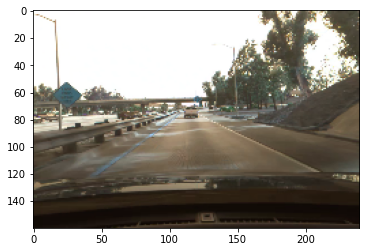

In [14]:
plt.imshow(img.permute(1, 2, 0))

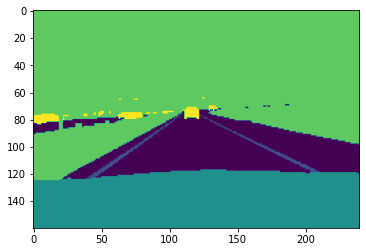

In [15]:
plt.imshow(mask)

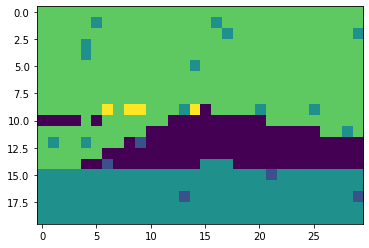

In [16]:
plt.imshow(mask_aux)

In [17]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bias=True, dilation=1, use_batchnorm=True):
        super().__init__()
        conv = nn.Conv2d(int(in_channels), int(out_channels), kernel_size=kernel_size, stride=stride, padding=padding, bias=bias, dilation=dilation)
        if use_batchnorm:
            self.block = nn.Sequential(
                conv,
                nn.BatchNorm2d(int(out_channels)),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                conv,
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        return self.block(x)

In [18]:
class BottleNeck(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride, dilation=1, use_batchnorm=True):
        super().__init__()
        bias = not use_batchnorm
        self.conv1 = ConvBlock(in_channels, mid_channels, 1, stride=1, padding=0, bias=bias, use_batchnorm=use_batchnorm)
        if dilation > 1:
            self.conv2 = ConvBlock(mid_channels, mid_channels, 3, stride=stride, padding=dilation, bias=bias, dilation=dilation, use_batchnorm=use_batchnorm)
        else:
            self.conv2 = ConvBlock(mid_channels, mid_channels, 3, stride=stride, padding=1, bias=bias, dilation=1, use_batchnorm=use_batchnorm)
        self.conv3 = ConvBlock(mid_channels, out_channels, 1, stride=1, padding=0, bias=bias, use_batchnorm=use_batchnorm)
        self.conv4 = ConvBlock(in_channels, out_channels, 1, stride=stride, padding=0, bias=bias, use_batchnorm=use_batchnorm)

    def forward(self, x):
        out1 = self.conv3(self.conv2(self.conv1(x)))
        out2 = self.conv4(x)
        return F.relu(out1 + out2, inplace=True)

In [19]:
class IdentityBottleNeck(nn.Module):
    def __init__(self, in_channels, mid_channels, stride, dilation=1, use_batchnorm=True):
        super().__init__()
        bias = not use_batchnorm
        self.conv1 = ConvBlock(in_channels, mid_channels, 1, stride=1, padding=0, bias=bias, use_batchnorm=use_batchnorm)
        if dilation > 1:
            self.conv2 = ConvBlock(mid_channels, mid_channels, 3, stride=1, padding=dilation, bias=bias, dilation=dilation, use_batchnorm=use_batchnorm)
        else:
            self.conv2 = ConvBlock(mid_channels, mid_channels, 3, stride=1, padding=1, bias=bias, dilation=1, use_batchnorm=use_batchnorm)
        self.conv3 = ConvBlock(mid_channels, in_channels, 1, stride=1, padding=0, bias=bias, use_batchnorm=use_batchnorm)

    def forward(self, x):
        out1 = self.conv3(self.conv2(self.conv1(x)))
        out2 = x
        return F.relu(out1 + out2, inplace=True)

In [20]:
class ResidualBlock(nn.Module):
    def __init__(self, n_layers, in_channels, mid_channels, out_channels, stride, dilation=1, include="all", use_batchnorm=True):
        super().__init__()
        stride = 1 if dilation > 1 else stride
        layers = []
        if include in ["all", "conv"]:
            layers.append(BottleNeck(in_channels, mid_channels, out_channels, stride, dilation, use_batchnorm=use_batchnorm))
        if include in ["all", "identity"]:
            for _ in range(n_layers - 1):
                layers.append(IdentityBottleNeck(out_channels, mid_channels, stride, dilation, use_batchnorm=use_batchnorm))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [21]:
class PyramidPooling(nn.Module):
    def __init__(self, in_channels, req_sizes):
        super().__init__()
        bn_flags = [True, True, True, False]
        bias_flags = [False, False, False, True]
        self.req_sizes = req_sizes        
        self.M = nn.ModuleList([
                                ConvBlock(in_channels, int(in_channels / len(req_sizes)), 1, 1, 0, bias=bias_flags[i], use_batchnorm=bn_flags[i]) 
                                for i in range(len(req_sizes))
                               ])

    def forward(self, x):
        h, w = x.shape[2:]
        kernel_sizes = []
        strides = []
        for req_size in self.req_sizes:
            kernel_sizes.append((int(h / req_size), int(w / req_size)))
            strides.append((int(h / req_size), int(w / req_size)))

        output_stacks = [x]
        for i, (req_size, module) in enumerate(zip(self.req_sizes, self.M)):
            out = F.avg_pool2d(x, kernel_sizes[i], stride=strides[i], padding=0)
            out = module(out)
            out = F.interpolate(out, size=(h, w), mode="bilinear", align_corners=True)
            output_stacks.append(out)
        return torch.cat(output_stacks, dim=1)

In [22]:
class PSPNet(nn.Module):                                    # resnet101
    def __init__(self, n_classes, input_shape, block_config=[3, 4, 23, 3]):
        super().__init__()
        self.n_classes = n_classes
        self.input_shape = input_shape
        self.conv1 = ConvBlock(3, 64, 3, padding=1, stride=2, bias=False)
        self.conv2 = ConvBlock(64, 64, 3, padding=1, stride=1, bias=False)
        self.conv3 = ConvBlock(64, 128, 3, padding=1, stride=1, bias=False)

        self.residual1 = ResidualBlock(block_config[0], 128, 64, 256, 1, 1)
        self.residual2 = ResidualBlock(block_config[1], 256, 128, 512, 2, 1)
        self.residual3 = ResidualBlock(block_config[2], 512, 256, 1024, 1, 2)

        self.aux_branch1 = ConvBlock(1024, 256, 3, padding=1, stride=1, bias=False)
        self.aux_branch2 = nn.Conv2d(256, self.n_classes, 1, 1, 0)

        self.residual4 = ResidualBlock(block_config[3], 1024, 512, 2048, 1, 4)
        self.pyramid_pool = PyramidPooling(2048, [6, 3, 2, 1])
        self.conv_final = ConvBlock(4096, 512, 3, 1, 1, False)
        self.dropout = nn.Dropout2d(p=0.1, inplace=False)
        self.final = nn.Conv2d(512, self.n_classes, 1, 1, 0)        

    def forward(self, x):
        h, w = x.shape[2:]
        x = self.conv3(self.conv2(self.conv1(x)))
        x = F.max_pool2d(x, 3, 2, 1)
        x = self.residual3(self.residual2(self.residual1(x)))
        if self.training:
            x_aux = self.aux_branch2(self.dropout(self.aux_branch1(x)))

        x = self.residual4(x)
        x = self.pyramid_pool(x)
        x = self.final(self.dropout(self.conv_final(x)))
        x = F.interpolate(x, size=(h, w), mode="bilinear", align_corners=True)
        if self.training:
            return (x, x_aux)
        else:
            return x

In [23]:
net = PSPNet(5, (img_width, img_height), [2, 2, 2, 2]).to(device) # resnet18

In [24]:
inp = torch.randn(1, 3, 160, 240).to(device)
net.train()
out, out_aux = net(inp)
out.shape, out_aux.shape

(torch.Size([1, 5, 160, 240]), torch.Size([1, 5, 20, 30]))

In [25]:
x = train_data[42][0].unsqueeze(0).to(device)
y = net(x)[0]
x.shape, y.shape

(torch.Size([1, 3, 160, 240]), torch.Size([1, 5, 160, 240]))

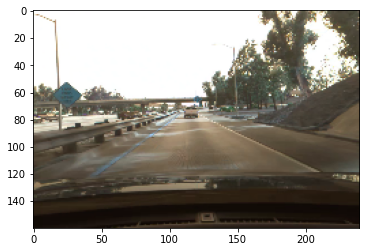

In [26]:
plt.imshow(x[0].permute(1, 2, 0).cpu())

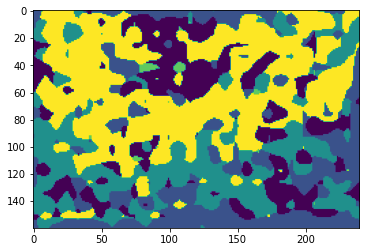

In [27]:
plt.imshow(y.softmax(1).argmax(1)[0].detach().cpu())

In [28]:
opt = torch.optim.Adam(net.parameters(), lr)
def loss_fn(input, target, input_aux=None, target_aux=None):
    n, c, h, w = input.shape
    nt, ht, wt = target.shape
    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    target = target.view(-1)
    loss1 = F.cross_entropy(input, target)
    if input_aux is not None:
        input_aux = input_aux.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
        target_aux = target_aux.view(-1)
        loss2 = F.cross_entropy(input_aux, target_aux)
    else:
        loss2 = 0
    loss = loss1 + (0.4 * loss2)
    return loss

def get_accuracy(preds, y):
    preds = preds.softmax(1).argmax(1)
    num_correct = preds.eq(y).sum()
    num_pixels = torch.numel(y)
    return num_correct / num_pixels

def display_images(X, preds, y):
    print("Displaying images:")
    print("")
    preds = preds.softmax(1).argmax(1)
    for i in range(5):
        plt.imshow(X[i].permute(1, 2, 0).cpu())
        plt.show()
        plt.imshow(preds[i].cpu())
        plt.show()
        plt.imshow(y[i].cpu())
        plt.show()
        print("")

In [29]:
def loop(batches, net, is_train):
    batch_losses = []
    batch_accs = []
    if is_train:
        print("Train Loop:")
        print("")
        net.train()
    else:
        print("Validation Loop:")
        print("")
        net.eval()

    for X, y1, y2 in tqdm.tqdm(batches, total=len(batches)):
        X = X.to(device)
        y1 = y1.long().to(device)
        y2 = y2.long().to(device)
        if is_train:
            preds, preds_aux = net(X)
            loss = loss_fn(preds, y1, preds_aux, y2)  
            acc = get_accuracy(preds, y1)
        else:
            with torch.no_grad():
                preds = net(X)
                loss = loss_fn(preds, y1)
                acc = get_accuracy(preds, y1)
        if is_train:
            opt.zero_grad()
            loss.backward()
            opt.step()

    batch_losses.append(loss.item())
    batch_accs.append(acc)

    if epoch % 5 == 0:
        display_images(X, preds.detach(), y1)
    print("")
    print("")
    return sum(batch_losses) / len(batch_losses), sum(batch_accs) / len(batch_accs)

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loop:



100%|██████████| 4/4 [04:15<00:00, 63.99s/it]


Displaying images:



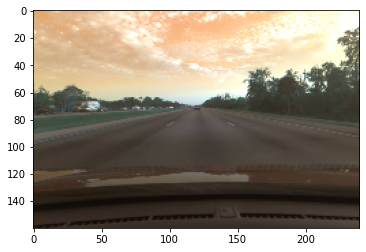

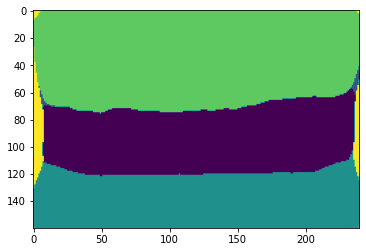

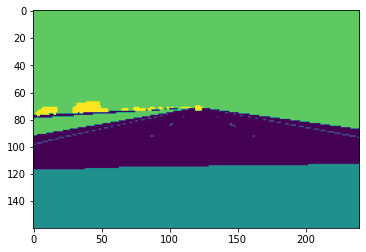

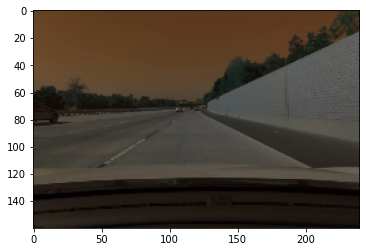

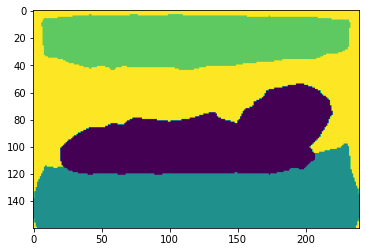

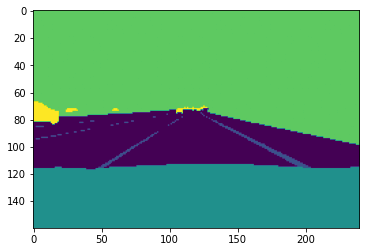

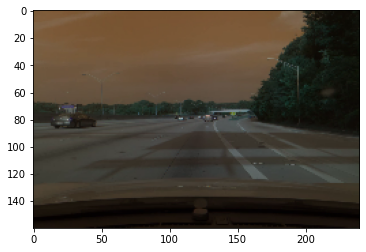

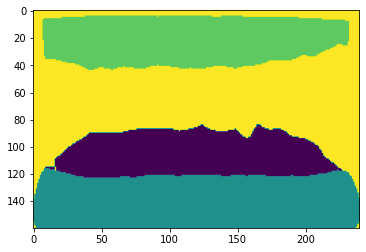

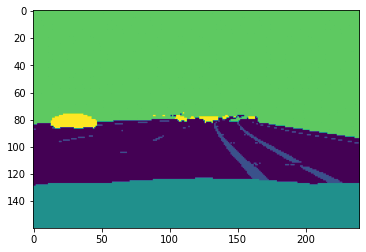

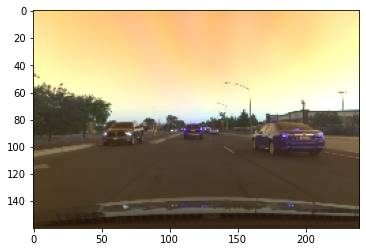

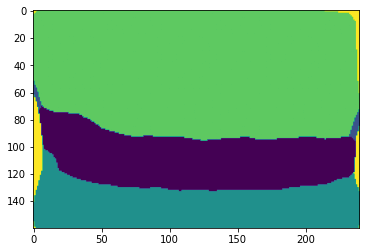

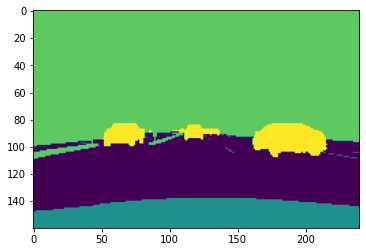

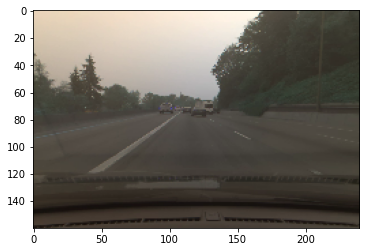

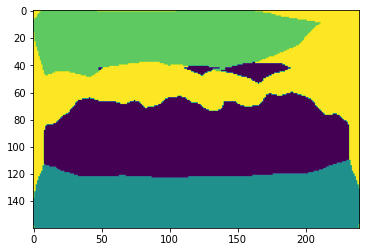

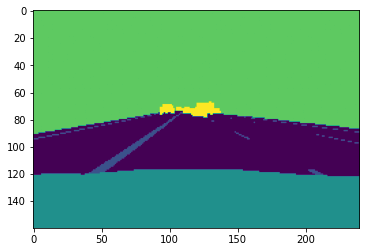

  0%|          | 0/4 [00:00<?, ?it/s]




epoch: 0 | train_loss: 1.3225 | train_acc: 0.6893

Train Loop:



  0%|          | 0/4 [00:00<?, ?it/s]



epoch: 1 | train_loss: 0.6596 | train_acc: 0.8974

Train Loop:



  0%|          | 0/4 [00:00<?, ?it/s]



epoch: 2 | train_loss: 0.4768 | train_acc: 0.9175

Train Loop:



  0%|          | 0/4 [00:00<?, ?it/s]



epoch: 3 | train_loss: 0.4573 | train_acc: 0.9243

Train Loop:



  0%|          | 0/4 [00:00<?, ?it/s]



epoch: 4 | train_loss: 0.4284 | train_acc: 0.9249

Train Loop:



100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


Displaying images:



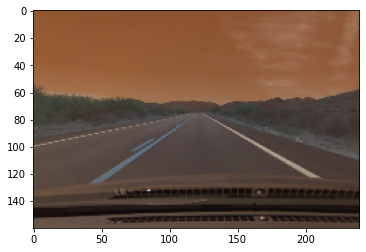

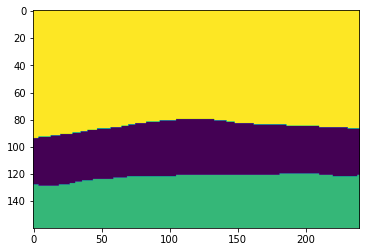

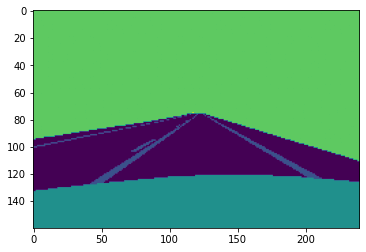

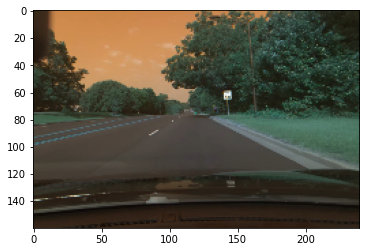

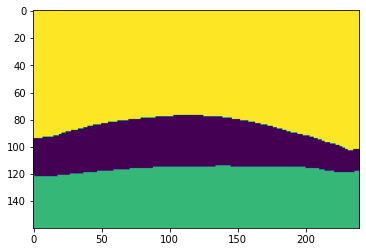

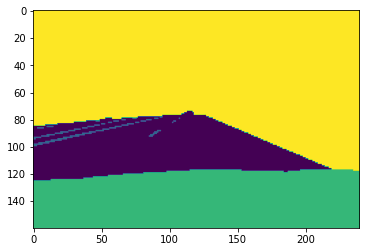

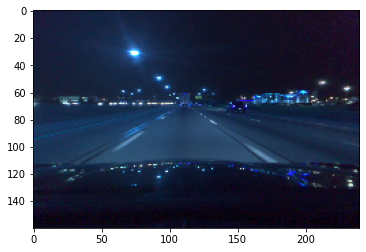

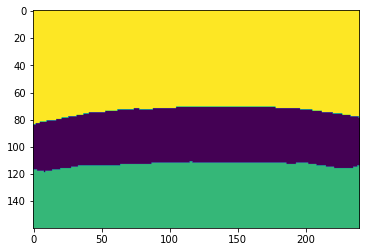

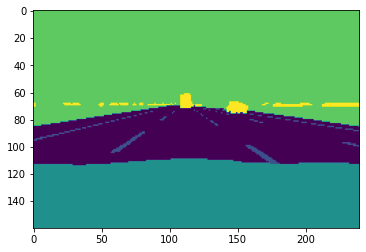

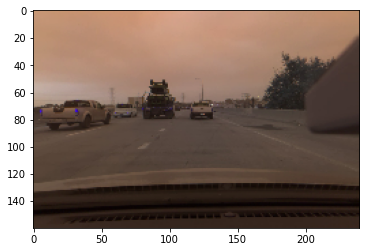

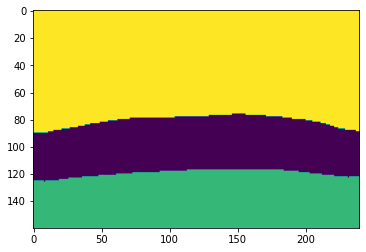

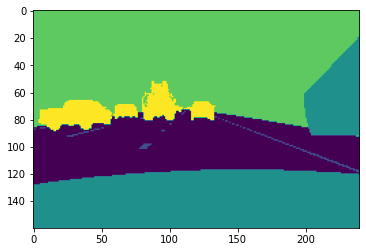

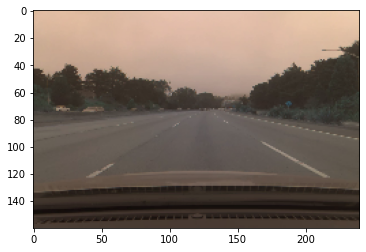

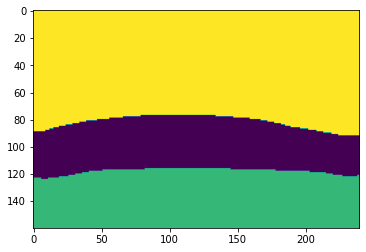

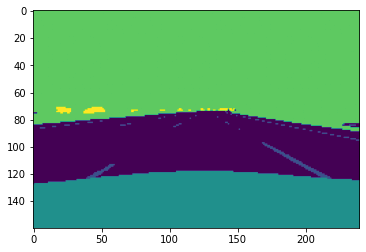

  0%|          | 0/4 [00:00<?, ?it/s]




epoch: 5 | train_loss: 0.3647 | train_acc: 0.9321

Train Loop:



  0%|          | 0/4 [00:00<?, ?it/s]



epoch: 6 | train_loss: 0.4022 | train_acc: 0.9268

Train Loop:



  0%|          | 0/4 [00:00<?, ?it/s]



epoch: 7 | train_loss: 0.6268 | train_acc: 0.8671

Train Loop:



  0%|          | 0/4 [00:00<?, ?it/s]



epoch: 8 | train_loss: 0.3173 | train_acc: 0.9425

Train Loop:



  0%|          | 0/4 [00:00<?, ?it/s]



epoch: 9 | train_loss: 0.3330 | train_acc: 0.9364

Train Loop:



100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


Displaying images:



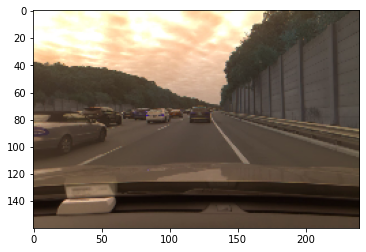

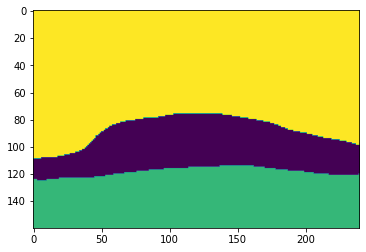

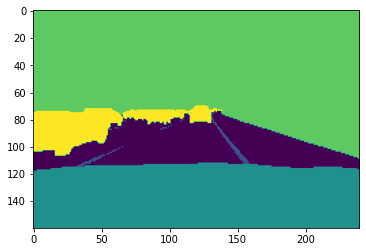

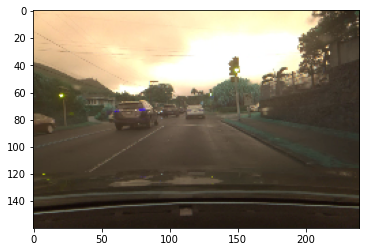

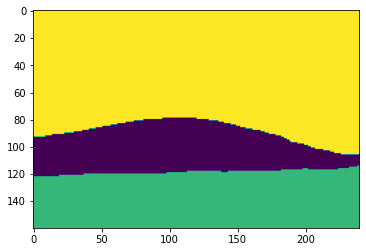

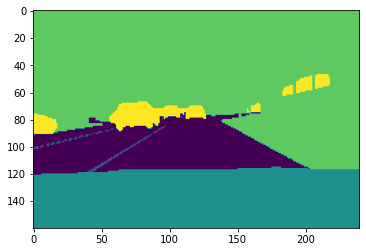

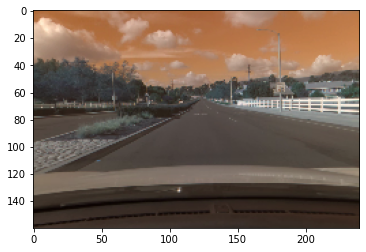

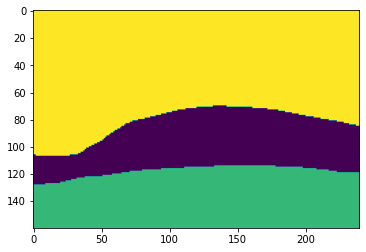

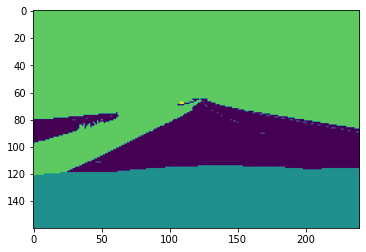

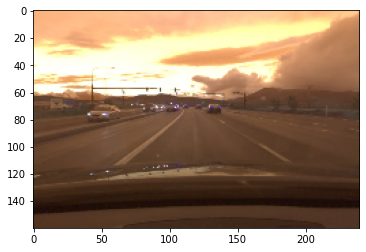

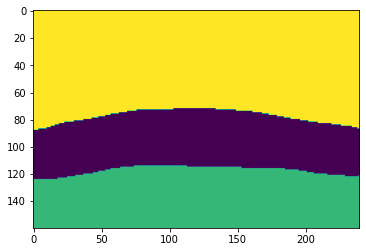

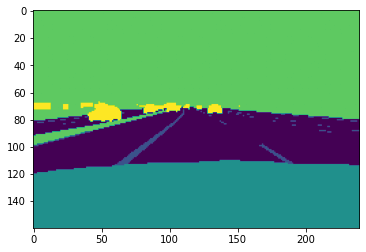

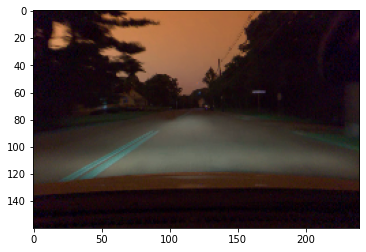

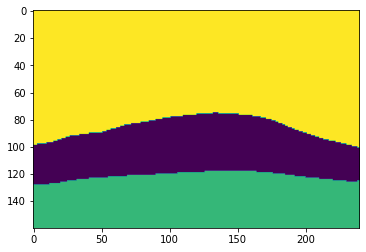

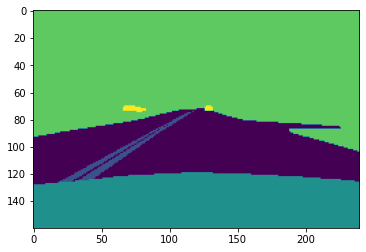

  0%|          | 0/4 [00:00<?, ?it/s]




epoch: 10 | train_loss: 0.3896 | train_acc: 0.9134

Train Loop:



  0%|          | 0/4 [00:00<?, ?it/s]



epoch: 11 | train_loss: 0.2807 | train_acc: 0.9487

Train Loop:



  0%|          | 0/4 [00:00<?, ?it/s]



epoch: 12 | train_loss: 0.3670 | train_acc: 0.9270

Train Loop:



  0%|          | 0/4 [00:00<?, ?it/s]



epoch: 13 | train_loss: 0.2947 | train_acc: 0.9492

Train Loop:



  0%|          | 0/4 [00:00<?, ?it/s]



epoch: 14 | train_loss: 0.2917 | train_acc: 0.9443

Train Loop:



100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


Displaying images:



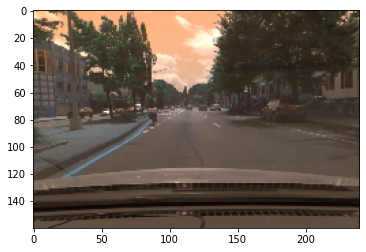

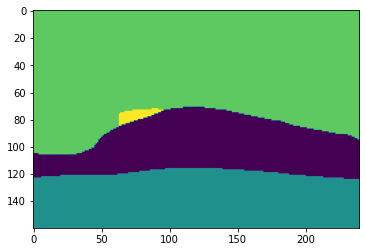

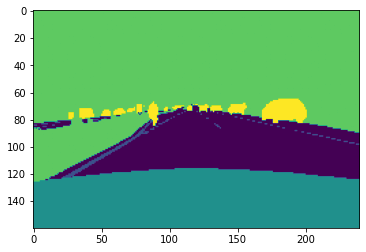

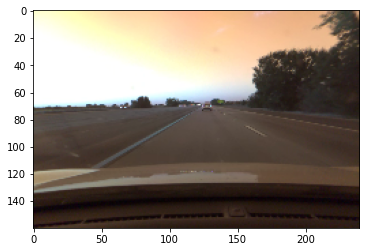

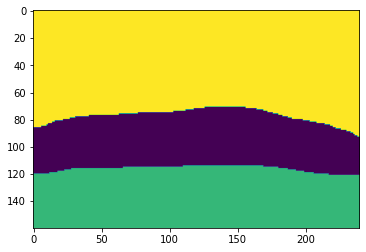

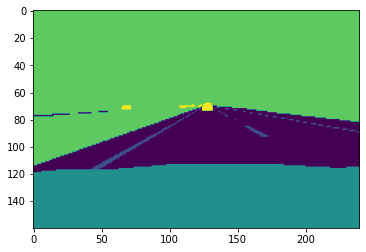

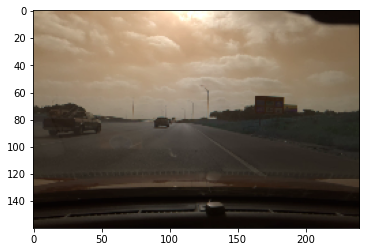

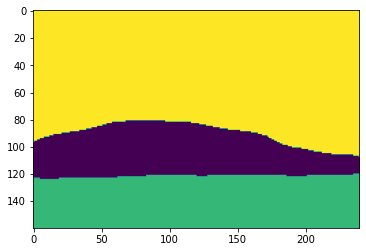

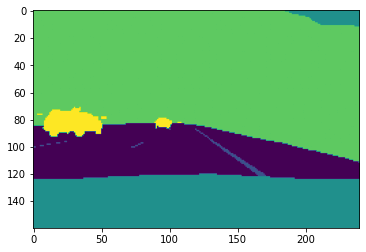

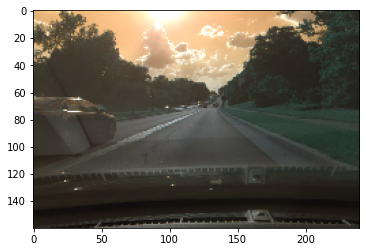

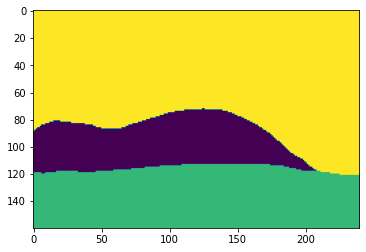

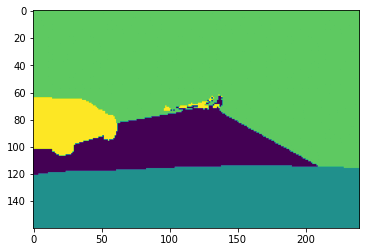

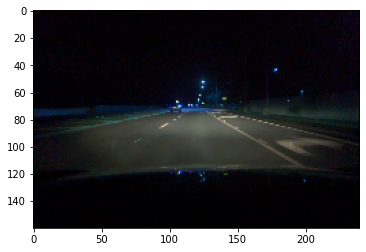

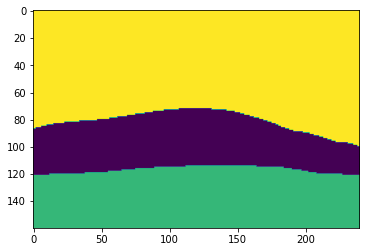

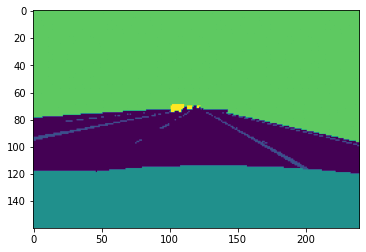

  0%|          | 0/4 [00:00<?, ?it/s]




epoch: 15 | train_loss: 0.2798 | train_acc: 0.9475

Train Loop:



  0%|          | 0/4 [00:00<?, ?it/s]



epoch: 16 | train_loss: 0.3044 | train_acc: 0.9399

Train Loop:



  0%|          | 0/4 [00:00<?, ?it/s]



epoch: 17 | train_loss: 0.2727 | train_acc: 0.9494

Train Loop:



  0%|          | 0/4 [00:00<?, ?it/s]



epoch: 18 | train_loss: 0.3260 | train_acc: 0.9340

Train Loop:



  0%|          | 0/4 [00:00<?, ?it/s]



epoch: 19 | train_loss: 0.2571 | train_acc: 0.9529

Train Loop:



100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


Displaying images:



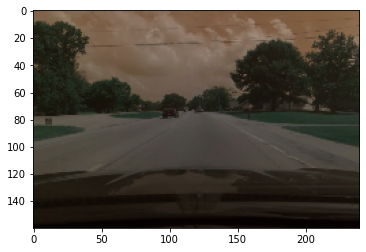

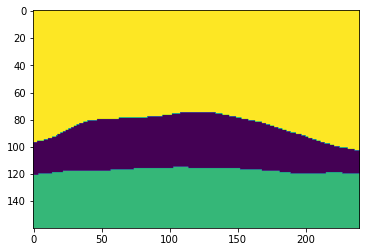

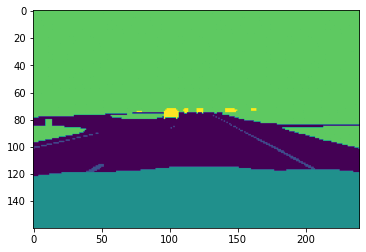

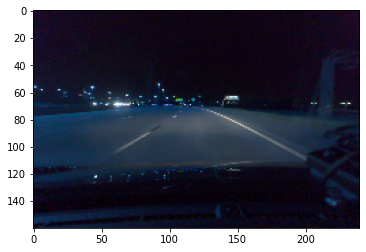

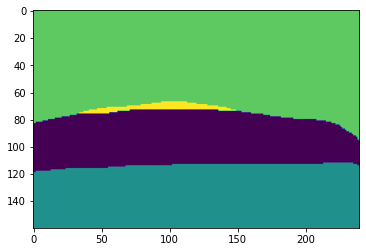

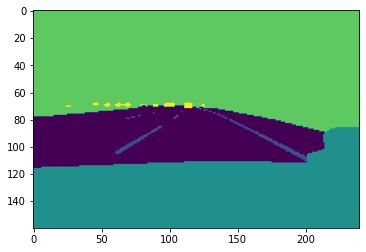

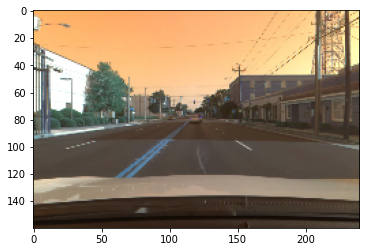

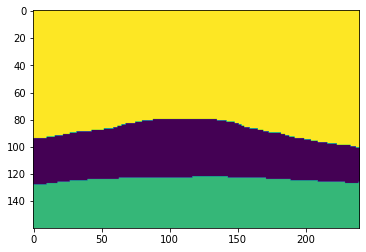

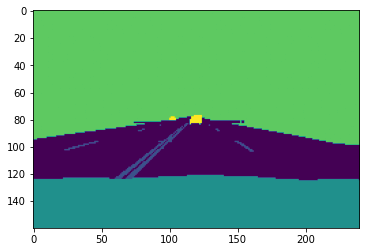

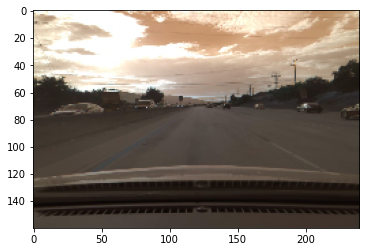

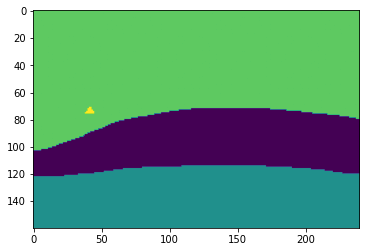

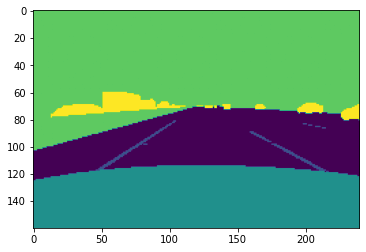

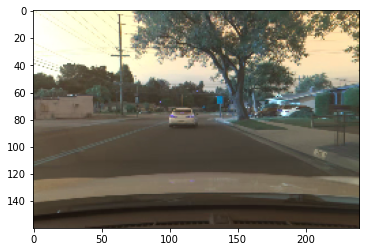

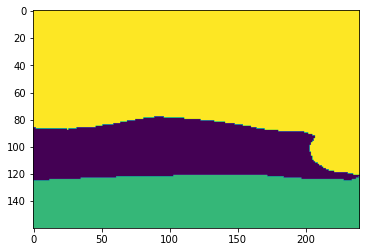

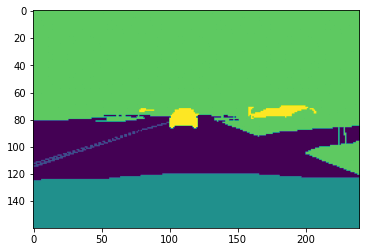

  0%|          | 0/4 [00:00<?, ?it/s]




epoch: 20 | train_loss: 0.2440 | train_acc: 0.9516

Train Loop:



  0%|          | 0/4 [00:00<?, ?it/s]



epoch: 21 | train_loss: 0.2928 | train_acc: 0.9400

Train Loop:



  0%|          | 0/4 [00:04<?, ?it/s]


KeyboardInterrupt: ignored

In [30]:
for epoch in range(epochs):
    train_loss, train_acc = loop(train_batches, net, True)
    # val_loss, val_acc = loop(val_batches, net, False)
    # print(f"epoch: {epoch} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f}")
    print(f"epoch: {epoch} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f}")
    print("")

In [31]:
def segment_images(img_ids):
    print("Displaying images:")
    print("")
    net.eval()
    for img_id in img_ids:
        x = train_data[img_id][0].unsqueeze(0).to(device)
        gt = train_data[img_id][1]
        with torch.no_grad():
            pred = net(x)

        pred = pred.softmax(1).argmax(1)
        plt.imshow(x[0].permute(1, 2, 0).cpu())
        plt.show()
        plt.imshow(gt)
        plt.show()
        plt.imshow(pred[0, :, :].detach().cpu())
        plt.show()
        print("")

Displaying images:



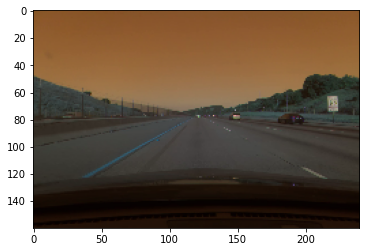

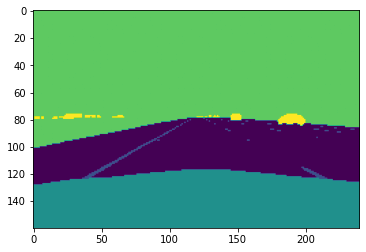

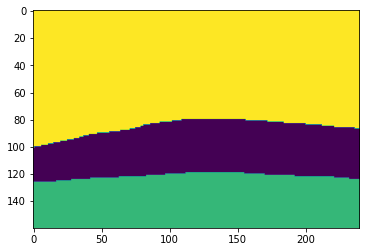

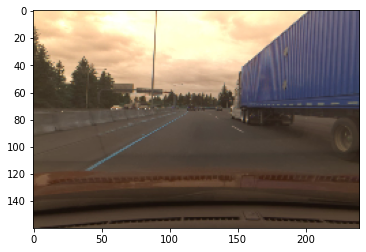

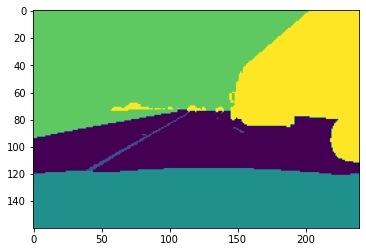

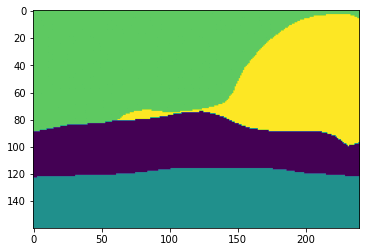

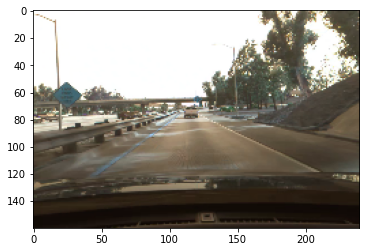

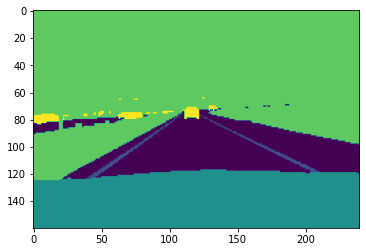

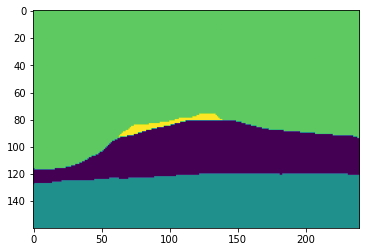

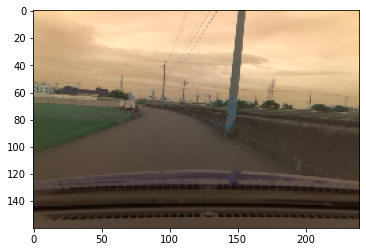

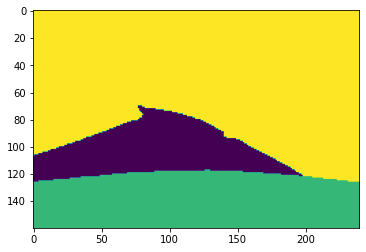

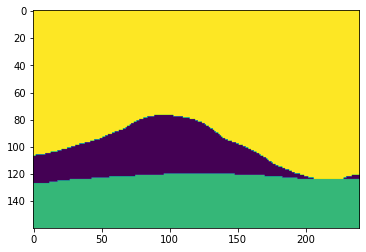

In [32]:
segment_images([4, 20, 42, 69]) # the results are obviously bad because it is trained on only 200 images and NN(resnet18 encoder) is just the vanilla configuration of PSPNet